<a href="https://colab.research.google.com/github/Sarik123-long/HDFC-Stock-Market-Prediction-and-Time-Series-Analysis/blob/main/HDFC_Stock_Market_Prediction_and_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install yfinance pandas matplotlib seaborn numpy scikit-learn tensorflow statsmodels


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings('ignore')


In [10]:
# Load HDFC Bank data from Yahoo Finance
ticker = "HDFCBANK.NS"
df = yf.download(ticker, start="2010-01-01", end="2025-01-01", interval="1d")

# Display first 5 rows and info
print(df.head())
print(df.info())


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open      Volume
Ticker     HDFCBANK.NS HDFCBANK.NS HDFCBANK.NS HDFCBANK.NS HDFCBANK.NS
Date                                                                  
2010-01-04   72.250305   73.216071   71.693294   72.008861     6100980
2010-01-05   72.313843   73.067817   72.220654   72.432445    16773200
2010-01-06   72.362556   72.856026   71.504800   72.601875    13279680
2010-01-07   72.551041   74.906153   72.076631   74.906153    12247960
2010-01-08   72.646362   73.000049   72.051231   72.517167    14171800
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3700 entries, 2010-01-04 to 2024-12-31
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Close, HDFCBANK.NS)   3700 non-null   float64
 1   (High, HDFCBANK.NS)    3700 non-null   float64
 2   (Low, HDFCBANK.NS)     3700 non-null   float64
 3   (Open, HDFCBANK.NS)    3700 non-null   floa

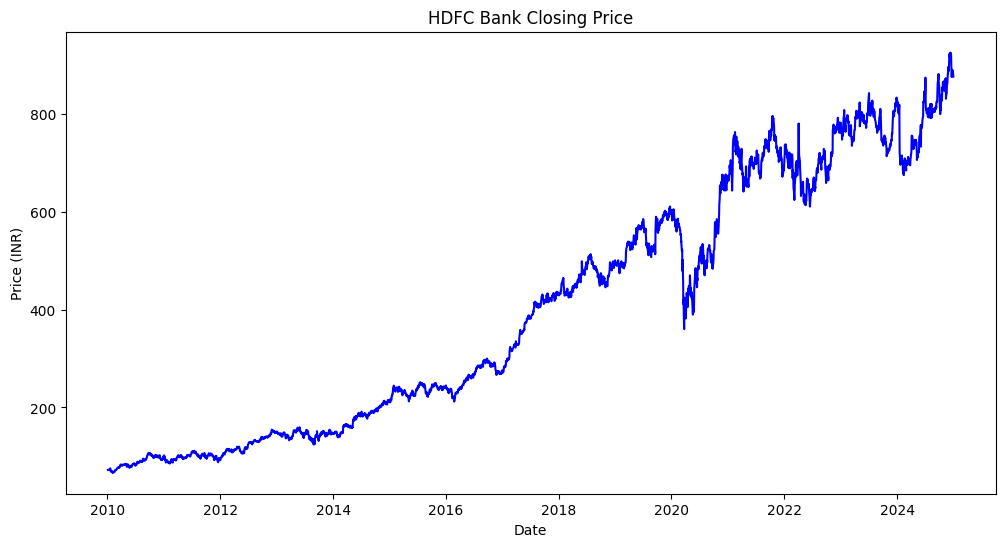

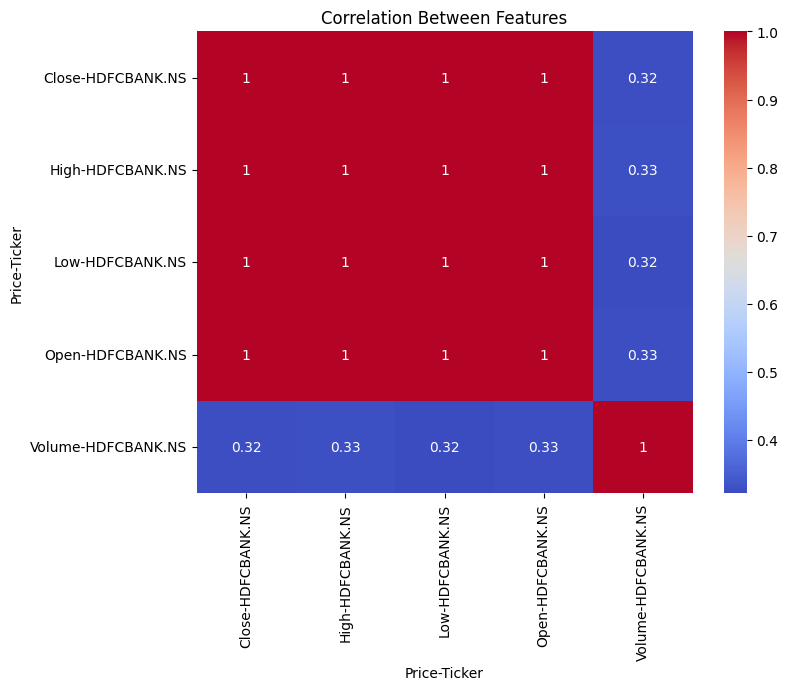

In [11]:
# Closing price trend
plt.figure(figsize=(12,6))
plt.plot(df['Close'], color='blue')
plt.title('HDFC Bank Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features')
plt.show()


ARIMA Forecast for next 30 days:
3700    876.929315
3701    877.287598
3702    877.106323
3703    876.812792
3704    876.760334
3705    876.788929
3706    876.799354
3707    876.787064
3708    876.778401
3709    876.778309
3710    876.779797
3711    876.779848
3712    876.779286
3713    876.779067
3714    876.779127
3715    876.779180
3716    876.779167
3717    876.779146
3718    876.779142
3719    876.779146
3720    876.779147
3721    876.779146
3722    876.779146
3723    876.779146
3724    876.779146
3725    876.779146
3726    876.779146
3727    876.779146
3728    876.779146
3729    876.779146
Name: predicted_mean, dtype: float64


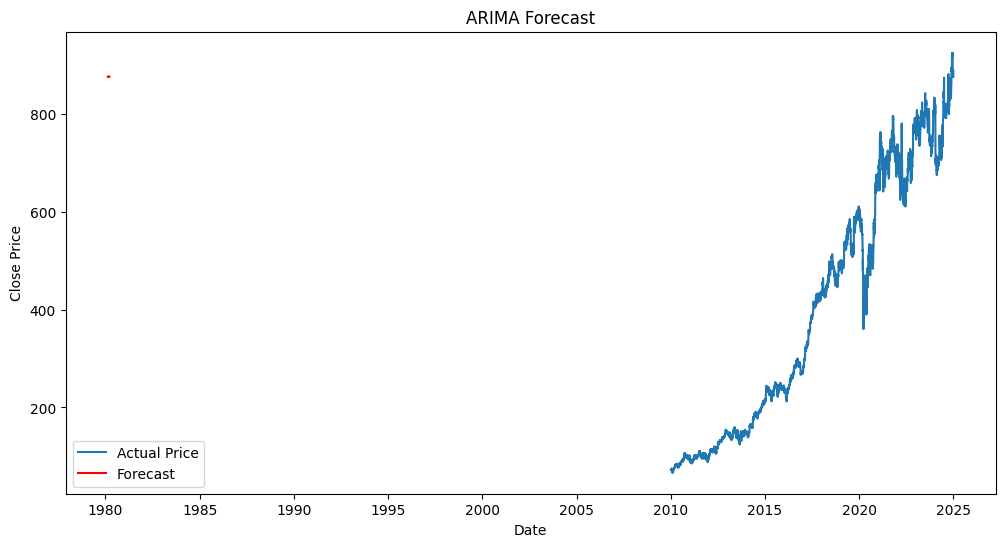

In [12]:
# Use only 'Close' prices
close_data = df['Close']

# Fit ARIMA model
arima_model = ARIMA(close_data, order=(5,1,0))
arima_result = arima_model.fit()

# Forecast next 30 days
forecast = arima_result.forecast(steps=30)
print("ARIMA Forecast for next 30 days:")
print(forecast)

# Plot ARIMA forecast
plt.figure(figsize=(12,6))
plt.plot(close_data, label='Actual Price')
plt.plot(forecast.index, forecast.values, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [14]:
# Prepare data
# Access 'Close' price using the multi-level index
data = df[('Close', 'HDFCBANK.NS')]
dataset = data.values.reshape(-1, 1) # Reshape to a 2D array for the scaler

training_data_len = int(np.ceil(len(dataset)*0.8))

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create training data
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

# Compile and train
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x_train, y_train, batch_size=32, epochs=5)


Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0204
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 2.4648e-04
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 2.6288e-04
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 2.8937e-04
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 2.1182e-04


In [16]:
# Test data
test_data = scaled_data[training_data_len-60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [17]:
# Predict
predictions = lstm_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
print(f"RMSE for LSTM: {rmse}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
RMSE for LSTM: 22.832454682716254


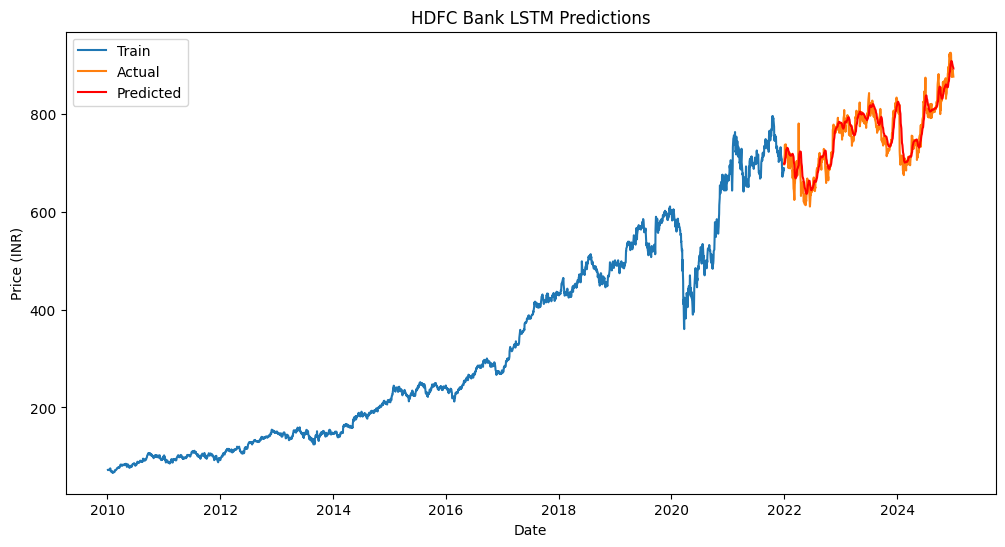

In [19]:
# Plot predictions
train = data[:training_data_len]
valid = data[training_data_len:]

# Create a new DataFrame for valid to add the predictions column
valid_df = valid.to_frame()
valid_df['Predictions'] = predictions

plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(valid_df[('Close', 'HDFCBANK.NS')], label='Actual')
plt.plot(valid_df['Predictions'], label='Predicted', color='red')
plt.title('HDFC Bank LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

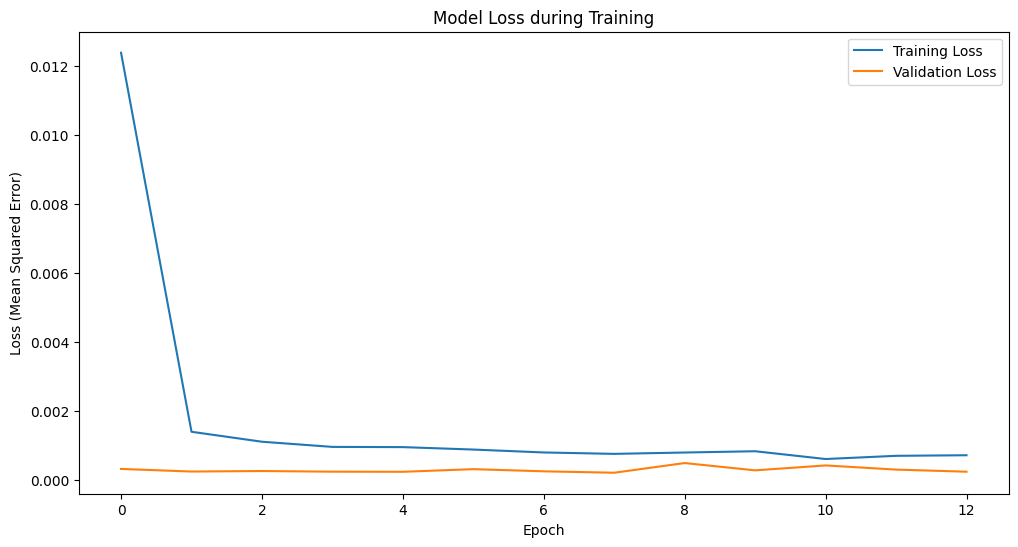

In [27]:
# Plot training and validation loss to check for overfitting
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

In [40]:
# Select the 'Close' price column
gru_data = df[('Close', 'HDFCBANK.NS')]

# Convert to NumPy array and reshape
gru_dataset = gru_data.values.reshape(-1, 1)

# Determine training data length
gru_training_data_len = int(np.ceil(len(gru_dataset) * 0.8))

# Scale data
gru_scaler = MinMaxScaler(feature_range=(0, 1))
gru_scaled_data = gru_scaler.fit_transform(gru_dataset)

# Create training data
gru_train_data = gru_scaled_data[0:gru_training_data_len, :]
gru_x_train = []
gru_y_train = []

for i in range(60, len(gru_train_data)):
    gru_x_train.append(gru_train_data[i-60:i, 0])
    gru_y_train.append(gru_train_data[i, 0])

# Convert to NumPy arrays and reshape x_train
gru_x_train, gru_y_train = np.array(gru_x_train), np.array(gru_y_train)
gru_x_train = np.reshape(gru_x_train, (gru_x_train.shape[0], gru_x_train.shape[1], 1))

In [41]:
from tensorflow.keras.layers import GRU

# Build GRU model
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(gru_x_train.shape[1],1)))
gru_model.add(GRU(50, return_sequences=False))
gru_model.add(Dense(25))
gru_model.add(Dense(1))

# Display the model summary
gru_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Compile the GRU model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
gru_history = gru_model.fit(gru_x_train, gru_y_train, batch_size=32, epochs=5)

Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 0.0083
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 9.9819e-05
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 1.2130e-04
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 9.0119e-05
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 7.5142e-05


In [43]:
# Prepare test data
gru_test_data = gru_scaled_data[gru_training_data_len - 60:, :]
gru_x_test = []
gru_y_test = gru_dataset[gru_training_data_len:, :]

for i in range(60, len(gru_test_data)):
    gru_x_test.append(gru_test_data[i-60:i, 0])

gru_x_test = np.array(gru_x_test)
gru_x_test = np.reshape(gru_x_test, (gru_x_test.shape[0], gru_x_test.shape[1], 1))

# Predict using the GRU model
gru_predictions = gru_model.predict(gru_x_test)
gru_predictions = gru_scaler.inverse_transform(gru_predictions)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


In [44]:
# Evaluate the GRU model
gru_rmse = np.sqrt(np.mean(((gru_predictions - gru_y_test)**2)))
print(f"RMSE for GRU: {gru_rmse}")

RMSE for GRU: 13.229521535360472


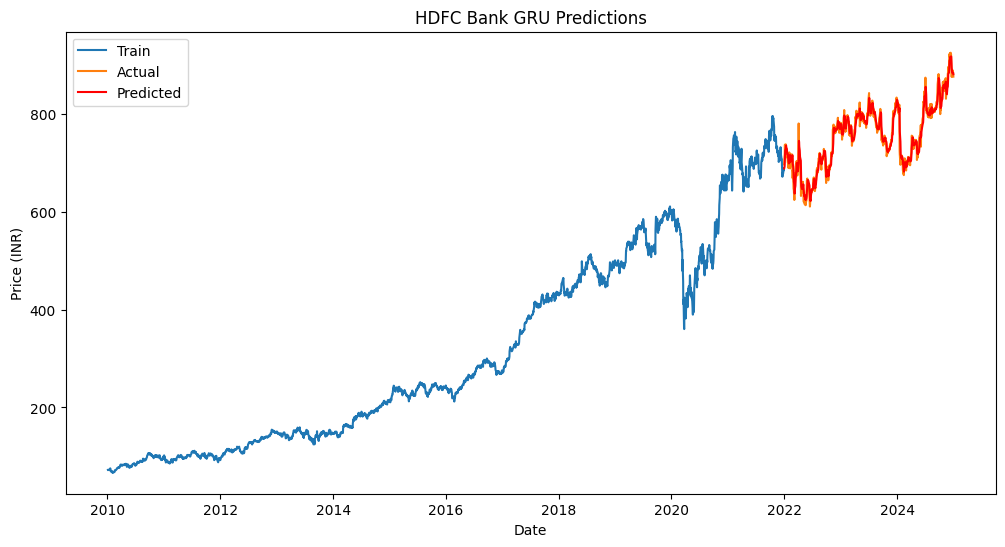

In [45]:
# Plot GRU predictions
gru_train = gru_data[:gru_training_data_len]
gru_valid = gru_data[gru_training_data_len:]

# Create a new DataFrame for gru_valid to add the predictions column
gru_valid_df = gru_valid.to_frame()
gru_valid_df['Predictions'] = gru_predictions

plt.figure(figsize=(12,6))
plt.plot(gru_train, label='Train')
plt.plot(gru_valid_df[('Close', 'HDFCBANK.NS')], label='Actual')
plt.plot(gru_valid_df['Predictions'], label='Predicted', color='red')
plt.title('HDFC Bank GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()